<a href="https://colab.research.google.com/github/pushkar/peer-tools/blob/master/notebooks/Optimal_Design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt

class Models(object):
    """
    A: A-opt minimizes the trace of the inverse of the information matrix. This results in minimizing the average variance of the estimates of the regression coefficients.
    D: D-opt maximizes the determinant of the information matrix of the design. This results in maximizing the differential Shannon information content of the parameter estimates.
    E: E-opt maximizes the minimum eigenvalue of the information matrix.
    T: T-opt maximizes the trace of the information matrix.
    """
    def __init__(self, F, C):
        self.F = F
        self.C = C
        self.A = None
        self.D = None
        self.E = None
        self.T = None
        self.G = None

        if self.F is not None and self.C is not None:        
            if self.C.size and self.F.size:
                self.A = np.trace(self.C)
            
            if self.F.size:
                self.D = np.linalg.det(self.F)
                if self.F.size > 1:
                    self.E = np.linalg.eigvals(self.F)
                self.T = np.trace(self.F)
                self.G = max(np.diagonal(self.F.dot(np.linalg.inv(self.F.T.dot(self.F)).dot(self.F.T))))

    def cov_area(self):
        if self.C is None:
            return 0
        return np.linalg.det(self.C)

    def stats(self):
        print("Fisher\n", self.F)
        print("Cov\n", self.C)
        print("A opt", self.A)
        print("D opt", self.D)
        print("E opt", self.E)
        print("T opt", self.T)
        print("G opt", self.G)

class Linear(Models):
    def __init__(self, data):
        fisher = None
        covariance = None
        matrix_guide = False
        if data.shape[0] > 1:
            fisher = np.identity(data.shape[1]) * 0.001

            if matrix_guide:
                # Using http://wittman.physics.ucdavis.edu/Fisher-matrix-guide.pdf
                for (x, sigma) in data:
                    for i in range(data.shape[1]):
                        if i == 0:
                            dfdpi = x
                        else:
                            dfdpi = 1
                        for j in range(data.shape[1]):
                            if j == 0:
                                dfdpj = x
                            else:
                                dfdpj = 1
                            fisher[i, j] += sigma ** -2 * dfdpi * dfdpj

                # Code using the math
                # fisher[0, 0] = np.apply_along_axis(lambda x: np.square(x[0])/np.square(x[1]), 1, data).sum()
                # fisher[1, 1] = np.apply_along_axis(lambda x: 1.0/np.square(x[1]), 1, data).sum()
                # fisher[0, 1] = np.apply_along_axis(lambda x: x[0]/np.square(x[1]), 1, data).sum()
                # fisher[1, 0] = fisher[0, 1]

                covariance = np.mat(fisher).I

            else:
                # Using https://web.stanford.edu/class/archive/stats/stats200/stats200.1172/Lecture25.pdf
                fisher = 100 * data.T @ data
                covariance = np.mat(fisher).I
            
        super().__init__(F=fisher, C=covariance)

support = np.array([[x, .1] for x in np.arange(0, 10, 1)])

stats = []
for i in support:
    for j in support:
        if np.array_equal(i, j):
            continue
        A = Linear(np.vstack([i, j])).A
        stats.append({
            'i': i[0],
            'j': j[0],
            'a': A
        })

pd.DataFrame(stats).sort_values('a').head(5)

,i,j,a
8,0.0,9.0,1.000247
81,9.0,0.0,1.000247
7,0.0,8.0,1.000312
72,8.0,0.0,1.000312
6,0.0,7.0,1.000408


B_hat [0.01422893 4.9866533 ]
SSE 1819.2473493040889
Variance B
 [[ 0.19668124 -0.01474183]
 [-0.01474183  0.00148159]]
Det(Variance) 7.40795614489962e-05


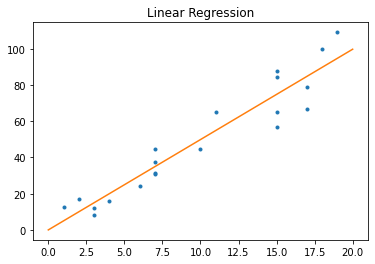

In [ ]:
# http://www.stat.columbia.edu/~fwood/Teaching/w4315/Fall2009/lecture_11
# https://www.stat.purdue.edu/~lingsong/teaching/2018spring/topic3.pdf


N = 20
X = np.array([[1, np.random.randint(20)] for _ in range(N)])
B = np.array([1, 5])
e = np.random.normal(0, 10, size=N)

Y = X @ B + e

# If inverse of X.T @ X exists
B_hat = np.linalg.inv(X.T @ X) @ X.T @ Y
print("B_hat", B_hat)

X_test = np.array([[1, 0], [1, 20]])
Y_test = X_test @ B_hat

SSE = Y.T @ Y - B_hat.T @ X.T @ Y
print("SSE", SSE)

Var_B = np.linalg.inv(X.T @ X)
print("Variance B\n", Var_B)
print("Det(Variance)", np.linalg.det(Var_B))

_ = plt.plot(X[:, 1], Y, '.')
_ = plt.plot(X_test[:, 1], Y_test)
_ = plt.title("Linear Regression")

In [ ]:
B_hat

array([0.01422893, 4.9866533 ])

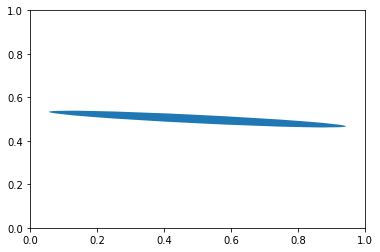

In [ ]:
from matplotlib.patches import Ellipse

def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

vals, vecs = eigsorted(Var_B)
theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

# Width and height are "full" widths, not radius
width, height = 1 * 2 * np.sqrt(vals)
ellip = Ellipse(xy=[0.5, 0.5], width=width, height=height, angle=theta)

ax = plt.gca();
ax.add_artist(ellip);

In [ ]:
vecs

array([[-0.99719217, -0.07488507],
       [ 0.07488507, -0.99719217]])

In [ ]:
np.degrees(np.arctan2(0.07390328, -0.99726541))

175.76178999330338

# Gaussian Process

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.figure()
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()

In [ ]:
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

[[16.0001 12.0001  8.0001  4.0001 -3.9999]
 [12.0001  9.0001  6.0001  3.0001 -2.9999]
 [ 8.0001  6.0001  4.0001  2.0001 -1.9999]
 [ 4.0001  3.0001  2.0001  1.0001 -0.9999]
 [-3.9999 -2.9999 -1.9999 -0.9999  1.0001]] -4.379057701029915e-50


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


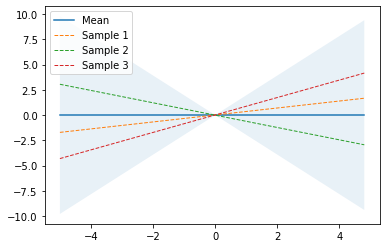

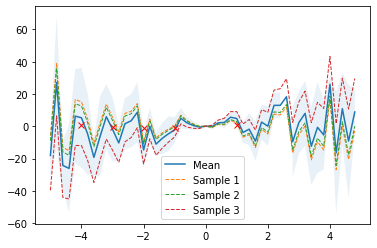

In [ ]:
from numpy.linalg import inv

def kernel(X1, X2, l=1.0, sigma_f=1.0):
    return np.dot(X1, X2.T) + 0.01 * np.identity(X1.shape[1]) * 0.01
    # return X1 @ X2.T + 0.01 * np.identity(X1.shape[1]) * 0.01

def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    '''
    Computes the suffifient statistics of the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    '''
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    print(K, np.linalg.det(K))
    K_inv = inv(K)
    
    # Equation (4)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (5)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

# Finite number of points
X = np.arange(-5, 5, 0.2).reshape(-1, 1)

# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = kernel(X, X)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

# Plot GP mean, confidence interval and samples
plot_gp(mu, cov, X, samples=samples)

# Noise free training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
Y_train = np.sin(X_train)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

In [ ]:
X_train

array([[-4],
       [-3],
       [-2],
       [-1],
       [ 1]])

In [ ]:
Y_train

array([[ 0.7568025 ],
       [-0.14112001],
       [-0.90929743],
       [-0.84147098],
       [ 0.84147098]])

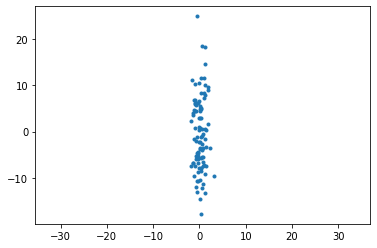

In [ ]:
mean = [0, 0]
cov = [[1, 0], [0, 50]]

x, y = np.random.multivariate_normal(mean, cov, 100).T
_ = plt.plot(x, y, '.')
_ = plt.axis('equal')


In [ ]:
x.shape

(100,)

In [ ]:
import sklearn
dir(sklearn.gaussian_process.kernels)

['ABCMeta',
 'CompoundKernel',
 'ConstantKernel',
 'DotProduct',
 'ExpSineSquared',
 'Exponentiation',
 'GenericKernelMixin',
 'Hyperparameter',
 'Kernel',
 'KernelOperator',
 'Matern',
 'NormalizedKernelMixin',
 'PairwiseKernel',
 'Product',
 'RBF',
 'RationalQuadratic',
 'StationaryKernelMixin',
 'Sum',
 'WhiteKernel',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_approx_fprime',
 '_check_length_scale',
 '_num_samples',
 'abstractmethod',
 'cdist',
 'clone',
 'gamma',
 'kv',
 'math',
 'namedtuple',
 'np',
 'pairwise_kernels',
 'pdist',
 'signature',
 'squareform',
 'warnings']

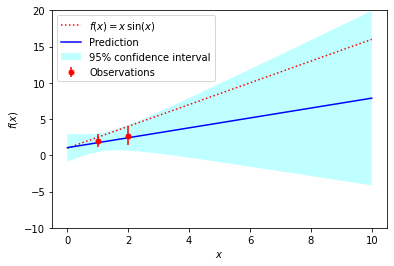

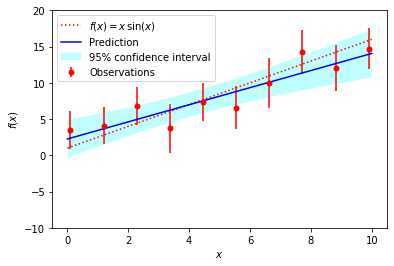

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel, ConstantKernel as C

np.random.seed(1)


def f(x):
    """The function to predict."""
    # return x * np.sin(x)
    return 1.5 * x + 1

# ----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1., 2.]).T
y = f(X).ravel()
dy = 0.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise

# Mesh the input space for evaluations of the real function, the prediction and its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Instantiate a Gaussian Process model
# kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
kernel = DotProduct() + WhiteKernel()
gp = GaussianProcessRegressor(kernel=kernel, alpha=dy ** 2, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
# plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]), np.concatenate([y_pred - 1.9600 * sigma, (y_pred + 1.9600 * sigma)[::-1]]), alpha=.25, fc='cyan', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

# ----------------------------------------------------------------------
# now the noisy case
X = np.linspace(0.1, 9.9, 10)
X = np.atleast_2d(X).T

# Observations and noise
y = f(X).ravel()
dy = 2.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise

# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, alpha=dy ** 2, n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]), np.concatenate([y_pred - 1.9600 * sigma, (y_pred + 1.9600 * sigma)[::-1]]), alpha=.25, fc='cyan', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

plt.show()

In [ ]:
y
